In [728]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU

from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [ ]:
# Show all cols in df.head()
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Revert to some cols
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')

# Uploading Dataset

In [729]:
games = pd.read_csv('data/game.csv', on_bad_lines='skip')

In [730]:
print(games.shape)
games.head()

(65698, 55)


,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,pts_home,plus_minus_home,video_available_home,team_id_away,team_abbreviation_away,team_name_away,matchup_away,wl_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,NaN,NaN,NaN,NaN,NaN,16.0,29.0,0.552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.0,-2,0,1610612752,NYK,New York Knicks,NYK @ HUS,W,24.0,NaN,NaN,NaN,NaN,NaN,20.0,26.0,0.769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2,0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,59.0,0.339,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,56.0,5,0,1610610031,PIT,Pittsburgh Ironmen,PIT @ BOM,L,16.0,72.0,0.222,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5,0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,6,0,1610612738,BOS,Boston Celtics,BOS @ PRO,L,21.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6,0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,63.0,16,0,1610612752,NYK,New York Knicks,NYK @ CHS,L,16.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16,0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,-17,0,1610610036,WAS,Washington Capitols,WAS @ DEF,W,18.0,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17,0,Regular Season


# Preprocessing

In [731]:
print(games['wl_home'].unique())
print(games['wl_home'].isna().sum())

['L' 'W' nan]
2


**Feature Encoding:** Use label encoder for wl_home, wl_away so they can be summed.

In [733]:
label_encoder = preprocessing.LabelEncoder()

# wl_home and wl_away W=1, L=0
games['wl_home']= label_encoder.fit_transform(games['wl_home'])
games['wl_away']= label_encoder.fit_transform(games['wl_away'])


Convert team abbreviations

In [646]:
# print(games[games['team_abbreviation_home'] == 'DEN'])

In [734]:
games = games[games['season_type'] != 'All Star']
games = games[games['season_type'] != 'All-Star']
games = games[games['season_type'] != 'Pre Season']


# teams = games['team_name_home'].unique()

# team_name_map = {}

# for team in teams:
#     team_abv = games[games['team_name_home'] == team]['team_abbreviation_home'].iloc[0]
#     team_name_map[team] = team_abv

# count = 0
# for key in team_name_map.keys():
#     count += 1
#     if count % 7 == 0:
#         print('\n')
#     print(str(key) + ": " + str(team_name_map[key]), end='    ')

# print(count)

In [735]:
team_abv_map = {
    # 'TCB': 'ATL',
    # 'MIH': 'ATL',
    'STL': 'ATL',
    # 'NJN': 'BKN',
    # 'CHA': 'CHH',
    'FTW': 'DET',
    # 'PHW': 'GSW',
    'SFW': 'GSW', 
    'GOS': 'GSW', # Normal
    # 'SDR': 'HOU',
    # 'BUF': 'LAC',
    'SDC': 'LAC',
    'MNL': 'LAL',
    # 'VAN': 'MEM',
    # 'NOH': 'NOP',
    # 'CHH': 'NOP',
    # 'NOK': 'NOP',
    # 'SEA': 'OKC',
    'SYR': 'PHI',
    'PHL': 'PHI', # Normal
    # 'ROC': 'SAC',
    'CIN': 'SAC',
    'KCK': 'SAC',
    # 'NOJ': 'UTH',
    # 'UTA': 'UTH',
    # 'CHZ': 'WAS',
    'BLT': 'WAS',
    'CAP':'WAS',
    # 'SAN': 'SAS',
    'DN': 'DEN' # Normal
    }

games['team_abbreviation_home'] = games['team_abbreviation_home'].replace(team_abv_map)
games['team_abbreviation_away'] = games['team_abbreviation_away'].replace(team_abv_map)
print(games['team_abbreviation_home'].unique())
print(games['team_name_home'].unique())
print(len(games['team_abbreviation_home'].unique()))
print(len(games['team_name_home'].unique()))

# teams_list = ['ATL', 'BOS', 'CHH', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'BKN', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'TOR', 'UTH', 'WAS', 'SAS']
# games = games[games['team_abbreviation_home'].isin(teams_list)]
# games = games[games['team_abbreviation_away'].isin(teams_list)]
# print(games['team_abbreviation_home'].unique())
# print(len(games['team_abbreviation_home'].unique()))

['HUS' 'BOM' 'PRO' 'CHS' 'DEF' 'CLR' 'PIT' 'BOS' 'PHW' 'NYK' 'WAS' 'BAL'
 'JET' 'DET' 'ROC' 'LAL' 'TCB' 'INO' 'WAT' 'AND' 'SHE' 'PHI' 'DEN' 'MIH'
 'ATL' 'SAC' 'CHZ' 'GSW' 'CHI' 'SDR' 'SEA' 'MIL' 'PHX' 'BUF' 'HOU' 'POR'
 'CLE' 'NOJ' 'SAN' 'IND' 'NJN' 'LAC' 'UTH' 'DAL' 'CHH' 'MIA' 'ORL' 'MIN'
 'TOR' 'VAN' 'UTA' 'SAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC' 'BKN' 'NOP']
['Toronto Huskies' 'St. Louis Bombers' 'Providence Steamrollers'
 'Chicago Stags' 'Detroit Falcons' 'Cleveland Rebels' 'Pittsburgh Ironmen'
 'Boston Celtics' 'Philadelphia Warriors' 'New York Knicks'
 'Washington Capitols' 'Baltimore Bullets' 'Indianapolis Jets'
 'Ft. Wayne Zollner Pistons' 'Rochester Royals' 'Minneapolis Lakers'
 'Tri-Cities Blackhawks' 'Indianapolis Olympians' 'Waterloo Hawks'
 'Anderson Packers' 'Sheboygan Redskins' 'Syracuse Nationals'
 'Denver Nuggets' 'Milwaukee Hawks' 'St. Louis Hawks' 'Detroit Pistons'
 'Cincinnati Royals' 'Los Angeles Lakers' 'Chicago Zephyrs'
 'San Francisco Warriors' 'Philadelphia 76ers' 

**Feature Engineering:** Create new features to summarize team statistics over previous games, as opposed to current game statistics. Create features to represent *(1) average points scored in last 5 and 10 games, (2) sum of wins in past 5 and 10 games, (3) whether or not team played back-to-back, (4) the number of games won in a row, and (5) the number of rest days between current and previous game* for home and away teams in each datapoint.

In [736]:
games['game_date'] = pd.to_datetime(games['game_date'])

# stats to add: home_last_5, away_last_5,
games['home_last_5'] = np.nan
games['away_last_5'] = np.nan
games['home_last_10'] = np.nan
games['away_last_10'] = np.nan

games['home_wins_5'] = np.nan
games['away_wins_5'] = np.nan
games['home_wins_10'] = np.nan
games['away_wins_10'] = np.nan

games['home_back_to_back'] = np.nan
games['away_back_to_back'] = np.nan

games['home_win_streak'] = np.nan
games['away_win_streak'] = np.nan

games['home_rest_days'] = np.nan
games['away_rest_days'] = np.nan


teams = games['team_abbreviation_home'].unique()

count = 0

# sample_id = None
# sample_found = False

for team in teams:
  # team_games contains every game team played in, sorted by date
  team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')

  # fill home_last_5, away_last_5 in team_games with avg of past 5 pts
  team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
  team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

  # test -----
  team_games['opp_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_away']
  team_games['opp_pts'] = team_games['opp_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_home'])

  team_games['pts_diff'] = team_games['team_pts'] - team_games['opp_pts']
  # test end -

  team_games['avg_pts'] = team_games['pts_diff'].shift(1).rolling(window=5).mean()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_last_5'] = team_games['avg_pts']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_last_5'] = team_games['avg_pts']
  team_games.drop(['team_pts', 'avg_pts', 'opp_pts', 'pts_diff'], axis=1, inplace=True)

  # find last 10 games avg pts
  team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
  team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

  # test -----
  team_games['opp_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_away']
  team_games['opp_pts'] = team_games['opp_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_home'])

  team_games['pts_diff'] = team_games['team_pts'] - team_games['opp_pts']
  # test end -

  team_games['avg_pts'] = team_games['pts_diff'].shift(1).rolling(window=10).mean()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_last_10'] = team_games['avg_pts']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_last_10'] = team_games['avg_pts']
  team_games.drop(['team_pts', 'avg_pts', 'opp_pts', 'pts_diff'], axis=1, inplace=True)

  # find last 5 wins sum
  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=5).sum()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_wins_5'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_wins_5'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # find last 10 wins sum
  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=10).sum()

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_wins_10'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_wins_10'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # find back-to-back games (if previous game was the day before)
  team_games['team_previous_date'] = team_games['game_date'].shift(1)

  team_games['back_to_back'] = np.where(team_games['game_date'] == (team_games['team_previous_date'] + pd.Timedelta(days=1)), 1, 0)
  def find_streak(window):
    sum = 0
    for item in window.iloc[::-1]:
      if item == 1:
        sum += 1
      else:
        return sum
    return sum
  team_games['btb_sum'] = team_games['back_to_back'].shift(1).rolling(window=10).apply(find_streak)

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_back_to_back'] = team_games['btb_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_back_to_back'] = team_games['btb_sum']
  team_games.drop(['team_previous_date', 'back_to_back', 'btb_sum'], axis=1, inplace=True)

  # win/loss streaks (how many games in a row won/lost before current game) (only up to 10)
  def find_streak(window):
    sum = 0
    for item in window.iloc[::-1]:
      if item == 1:
        sum += 1
      else:
        return sum
    return sum

  team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
  team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

  team_games['wins_sum'] = team_games['team_wins'].shift(1).rolling(window=10).apply(find_streak)

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_win_streak'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_win_streak'] = team_games['wins_sum']
  team_games.drop(['team_wins', 'wins_sum'], axis=1, inplace=True)

  # Number of rest days leading up to game
  team_games['team_previous_date'] = team_games['game_date'].shift(1)

  team_games['rest_days'] = team_games['game_date'] - team_games['team_previous_date']
  team_games['rest_days'] = team_games['rest_days'].dt.days

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_rest_days'] = team_games['rest_days']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_rest_days'] = team_games['rest_days']
  team_games.drop(['team_previous_date', 'rest_days'], axis=1, inplace=True)

  # past 5/10 team wins at home/away
  team_games['wins_sum'] = team_games.loc[team_games['team_abbreviation_home'] == team, 'wl_home'].shift(1).rolling(window=5, min_periods=1).sum()
  team_games['wins_sum'] = team_games['wins_sum'].fillna(team_games.loc[team_games['team_abbreviation_away'] == team, 'wl_away'].shift(1).rolling(window=5, min_periods=1).sum())

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_home_wins_5'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_away_wins_5'] = team_games['wins_sum']
  team_games.drop(['wins_sum'], axis=1, inplace=True)

  team_games['wins_sum'] = team_games.loc[team_games['team_abbreviation_home'] == team, 'wl_home'].shift(1).rolling(window=10, min_periods=1).sum()
  team_games['wins_sum'] = team_games['wins_sum'].fillna(team_games.loc[team_games['team_abbreviation_away'] == team, 'wl_away'].shift(1).rolling(window=10, min_periods=1).sum())

  team_games.loc[team_games['team_abbreviation_home'] == team, 'home_home_wins_10'] = team_games['wins_sum']
  team_games.loc[team_games['team_abbreviation_away'] == team, 'away_away_wins_10'] = team_games['wins_sum']
  team_games.drop(['wins_sum'], axis=1, inplace=True)

  # update games.loc with new features.
  games = games.combine_first(team_games)

  count += 1
  print("\rTeam " + str(count) + "/" + str(len(teams)), end='')

  # FOR TESTING (sample 10 consecutive points)
  #  # print(team_games.sample(n=1))
  # start_idx = np.random.randint(0, len(team_games) - 10 + 1)
  # consecutive_sample = team_games.iloc[start_idx:start_idx + 10]
  # print(consecutive_sample[['team_abbreviation_home', 'team_abbreviation_away', 'game_date', 'pts_home', 'home_last_5', 'away_last_5']])
  # break

print(games.shape)
games.head()


Team 59/59(64034, 73)


,ast_away,ast_home,away_away_wins_10,away_away_wins_5,away_back_to_back,away_last_10,away_last_5,away_rest_days,away_win_streak,away_wins_10,away_wins_5,blk_away,blk_home,dreb_away,dreb_home,fg3_pct_away,fg3_pct_home,fg3a_away,fg3a_home,fg3m_away,fg3m_home,fg_pct_away,fg_pct_home,fga_away,fga_home,fgm_away,fgm_home,ft_pct_away,ft_pct_home,fta_away,fta_home,ftm_away,ftm_home,game_date,game_id,home_back_to_back,home_home_wins_10,home_home_wins_5,home_last_10,home_last_5,home_rest_days,home_win_streak,home_wins_10,home_wins_5,matchup_away,matchup_home,min,oreb_away,oreb_home,pf_away,pf_home,plus_minus_away,plus_minus_home,pts_away,pts_home,reb_away,reb_home,season_id,season_type,stl_away,stl_home,team_abbreviation_away,team_abbreviation_home,team_id_away,team_id_home,team_name_away,team_name_home,tov_away,tov_home,video_available_away,video_available_home,wl_away,wl_home
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,25.0,0.769,0.552,26.0,29.0,20.0,16.0,1946-11-01,24600001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ HUS,HUS vs. NYK,0,NaN,NaN,NaN,NaN,2,-2,68.0,66.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,HUS,1610612752,1610610035,New York Knicks,Toronto Huskies,NaN,NaN,0,0,1,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.339,72.0,59.0,16.0,20.0,NaN,NaN,NaN,NaN,19.0,16.0,1946-11-02,24600003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT @ BOM,BOM vs. PIT,0,NaN,NaN,25.0,21.0,-5,5,51.0,56.0,NaN,NaN,21946,Regular Season,NaN,NaN,PIT,BOM,1610610031,1610610034,Pittsburgh Ironmen,St. Louis Bombers,NaN,NaN,0,0,0,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,21.0,NaN,NaN,NaN,NaN,11.0,17.0,1946-11-02,24600002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOS @ PRO,PRO vs. BOS,0,NaN,NaN,NaN,NaN,-6,6,53.0,59.0,NaN,NaN,21946,Regular Season,NaN,NaN,BOS,PRO,1610612738,1610610032,Boston Celtics,Providence Steamrollers,NaN,NaN,0,0,0,1
3,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,21.0,NaN,NaN,NaN,NaN,15.0,21.0,1946-11-02,24600004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ CHS,CHS vs. NYK,0,NaN,NaN,22.0,20.0,-16,16,47.0,63.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,CHS,1610612752,1610610025,New York Knicks,Chicago Stags,NaN,NaN,0,0,0,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,10.0,NaN,NaN,NaN,NaN,14.0,13.0,1946-11-02,24600005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAS @ DEF,DEF vs. WAS,0,NaN,NaN,NaN,NaN,17,-17,50.0,33.0,NaN,NaN,21946,Regular Season,NaN,NaN,WAS,DEF,1610610036,1610610028,Washington Capitols,Detroit Falcons,NaN,NaN,0,0,1,0


**Feature Engineering:** Add features representing the wins of either team in their previous 3, 6, and 9 matchups.

In [737]:
games['home_matchup_wins_3'] = np.nan
games['away_matchup_wins_3'] = np.nan
games['home_matchup_wins_6'] = np.nan
games['away_matchup_wins_6'] = np.nan
games['home_matchup_wins_10'] = np.nan
games['away_matchup_wins_10'] = np.nan

count = 0

# Trying to separate matchups stuff from the rest
for team in teams:
    # team_games contains every game team played in, sorted by date
    team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')
    
    # create 'opponent' feature
    team_games.loc[team_games['team_abbreviation_home'] == team, 'opponent'] = team_games['team_abbreviation_away']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'opponent'] = team_games['team_abbreviation_home']

    # make team_wins feature to store current teams win/loss status
    team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
    team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_home'])

    # 
    team_games['matchup_wins_3'] = team_games.groupby('opponent')['team_wins'].shift(1).rolling(window=3, min_periods=1).sum()
    team_games['matchup_wins_6'] = team_games.groupby('opponent')['team_wins'].shift(1).rolling(window=6, min_periods=1).sum()
    team_games['matchup_wins_10'] = team_games.groupby('opponent')['team_wins'].shift(1).rolling(window=10, min_periods=1).sum()

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_3'] = team_games['matchup_wins_3']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_3'] = team_games['matchup_wins_3']
    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_6'] = team_games['matchup_wins_6']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_6'] = team_games['matchup_wins_6']
    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_matchup_wins_10'] = team_games['matchup_wins_10']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_matchup_wins_10'] = team_games['matchup_wins_10']
    team_games.drop(['matchup_wins_3', 'matchup_wins_6', 'matchup_wins_10',
                     'team_wins', 'opponent'], axis=1, inplace=True)

    games = games.combine_first(team_games)

    count += 1
    print("\rTeam " + str(count) + "/" + str(len(teams)), end='')   

print(games.shape)
games.head()   

Team 59/59(64034, 79)


,ast_away,ast_home,away_away_wins_10,away_away_wins_5,away_back_to_back,away_last_10,away_last_5,away_rest_days,away_win_streak,away_wins_10,away_wins_5,blk_away,blk_home,dreb_away,dreb_home,fg3_pct_away,fg3_pct_home,fg3a_away,fg3a_home,fg3m_away,fg3m_home,fg_pct_away,fg_pct_home,fga_away,fga_home,fgm_away,fgm_home,ft_pct_away,ft_pct_home,fta_away,fta_home,ftm_away,ftm_home,game_date,game_id,home_back_to_back,home_home_wins_10,home_home_wins_5,home_last_10,home_last_5,home_rest_days,home_win_streak,home_wins_10,home_wins_5,matchup_away,matchup_home,min,oreb_away,oreb_home,pf_away,pf_home,plus_minus_away,plus_minus_home,pts_away,pts_home,reb_away,reb_home,season_id,season_type,stl_away,stl_home,team_abbreviation_away,team_abbreviation_home,team_id_away,team_id_home,team_name_away,team_name_home,tov_away,tov_home,video_available_away,video_available_home,wl_away,wl_home,home_matchup_wins_3,away_matchup_wins_3,home_matchup_wins_6,away_matchup_wins_6,home_matchup_wins_10,away_matchup_wins_10
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,25.0,0.769,0.552,26.0,29.0,20.0,16.0,1946-11-01,24600001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ HUS,HUS vs. NYK,0,NaN,NaN,NaN,NaN,2,-2,68.0,66.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,HUS,1610612752,1610610035,New York Knicks,Toronto Huskies,NaN,NaN,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.339,72.0,59.0,16.0,20.0,NaN,NaN,NaN,NaN,19.0,16.0,1946-11-02,24600003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT @ BOM,BOM vs. PIT,0,NaN,NaN,25.0,21.0,-5,5,51.0,56.0,NaN,NaN,21946,Regular Season,NaN,NaN,PIT,BOM,1610610031,1610610034,Pittsburgh Ironmen,St. Louis Bombers,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,21.0,NaN,NaN,NaN,NaN,11.0,17.0,1946-11-02,24600002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOS @ PRO,PRO vs. BOS,0,NaN,NaN,NaN,NaN,-6,6,53.0,59.0,NaN,NaN,21946,Regular Season,NaN,NaN,BOS,PRO,1610612738,1610610032,Boston Celtics,Providence Steamrollers,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,21.0,NaN,NaN,NaN,NaN,15.0,21.0,1946-11-02,24600004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ CHS,CHS vs. NYK,0,NaN,NaN,22.0,20.0,-16,16,47.0,63.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,CHS,1610612752,1610610025,New York Knicks,Chicago Stags,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,10.0,NaN,NaN,NaN,NaN,14.0,13.0,1946-11-02,24600005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAS @ DEF,DEF vs. WAS,0,NaN,NaN,NaN,NaN,17,-17,50.0,33.0,NaN,NaN,21946,Regular Season,NaN,NaN,WAS,DEF,1610610036,1610610028,Washington Capitols,Detroit Falcons,NaN,NaN,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN


**Feature Engineering:** Add features representing the cumulative seasonal averages of different statistics like wins and points.

***IMPORTANT: Future plan: create a value to represent entire seasons counting pre/regular/post season***

In [738]:
games['home_seasonal_win_pct'] = np.nan
games['away_seasonal_win_pct'] = np.nan
games['home_seasonal_pt_diff'] = np.nan
games['away_seasonal_pt_diff'] = np.nan

count = 0

for team in teams:
    # team_games contains every game team played in, sorted by date
    team_games = games[(games["team_abbreviation_home"] == team) | (games["team_abbreviation_away"] == team)].sort_values(by='game_date')

    # add cumulative mean of wins (w/l) throughout each season
    team_games['team_wins'] = team_games[team_games["team_abbreviation_home"] == team]['wl_home']
    team_games['team_wins'] = team_games['team_wins'].fillna(team_games[team_games["team_abbreviation_away"] == team]['wl_away'])

    team_games['team_seasonal_win_pct'] = team_games.groupby('season_id')['team_wins'].expanding().mean().reset_index(level=0, drop=True).shift(1)
    team_games.loc[team_games.groupby('season_id')['team_wins'].head(1).index, 'team_seasonal_win_pct'] = 0.0

    team_games['team_seasonal_win_pct'] = round(team_games['team_seasonal_win_pct'], 5)

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_seasonal_win_pct'] = team_games['team_seasonal_win_pct']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_seasonal_win_pct'] = team_games['team_seasonal_win_pct']
    team_games.drop(['team_wins', 'team_seasonal_win_pct'], axis=1, inplace=True)

    # add cumulative mean of pts scored throughout each season
    team_games['team_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_home']
    team_games['team_pts'] = team_games['team_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_away'])

    team_games['opp_pts'] = team_games[team_games["team_abbreviation_home"] == team]['pts_away']
    team_games['opp_pts'] = team_games['opp_pts'].fillna(team_games[team_games["team_abbreviation_away"] == team]['pts_home'])

    team_games['pt_diff'] = team_games['team_pts'] - team_games['opp_pts']

    team_games['team_seasonal_pt_diff'] = team_games.groupby('season_id')['pt_diff'].expanding().mean().reset_index(level=0, drop=True).shift(1)
    team_games.loc[team_games.groupby('season_id')['team_pts'].head(1).index, 'team_seasonal_pt_diff'] = 0.0

    team_games['team_seasonal_pt_diff'] = round(team_games['team_seasonal_pt_diff'], 5)

    team_games.loc[team_games['team_abbreviation_home'] == team, 'home_seasonal_pt_diff'] = team_games['team_seasonal_pt_diff']
    team_games.loc[team_games['team_abbreviation_away'] == team, 'away_seasonal_pt_diff'] = team_games['team_seasonal_pt_diff']
    team_games.drop(['team_pts', 'opp_pts', 'pt_diff', 'team_seasonal_pt_diff'], axis=1, inplace=True)

    games = games.combine_first(team_games)

    count += 1
    print("\rTeam " + str(count) + "/" + str(len(teams)), end='')

# (Maybe): per season, compare win percentages across teams and add a feature for ranking

print(games.shape)
games.head()

Team 59/59(64034, 83)


,ast_away,ast_home,away_away_wins_10,away_away_wins_5,away_back_to_back,away_last_10,away_last_5,away_rest_days,away_win_streak,away_wins_10,away_wins_5,blk_away,blk_home,dreb_away,dreb_home,fg3_pct_away,fg3_pct_home,fg3a_away,fg3a_home,fg3m_away,fg3m_home,fg_pct_away,fg_pct_home,fga_away,fga_home,fgm_away,fgm_home,ft_pct_away,ft_pct_home,fta_away,fta_home,ftm_away,ftm_home,game_date,game_id,home_back_to_back,home_home_wins_10,home_home_wins_5,home_last_10,home_last_5,home_rest_days,home_win_streak,home_wins_10,home_wins_5,matchup_away,matchup_home,min,oreb_away,oreb_home,pf_away,pf_home,plus_minus_away,plus_minus_home,pts_away,pts_home,reb_away,reb_home,season_id,season_type,stl_away,stl_home,team_abbreviation_away,team_abbreviation_home,team_id_away,team_id_home,team_name_away,team_name_home,tov_away,tov_home,video_available_away,video_available_home,wl_away,wl_home,home_matchup_wins_3,away_matchup_wins_3,home_matchup_wins_6,away_matchup_wins_6,home_matchup_wins_10,away_matchup_wins_10,home_seasonal_win_pct,away_seasonal_win_pct,home_seasonal_pt_diff,away_seasonal_pt_diff
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,25.0,0.769,0.552,26.0,29.0,20.0,16.0,1946-11-01,24600001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ HUS,HUS vs. NYK,0,NaN,NaN,NaN,NaN,2,-2,68.0,66.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,HUS,1610612752,1610610035,New York Knicks,Toronto Huskies,NaN,NaN,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.339,72.0,59.0,16.0,20.0,NaN,NaN,NaN,NaN,19.0,16.0,1946-11-02,24600003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PIT @ BOM,BOM vs. PIT,0,NaN,NaN,25.0,21.0,-5,5,51.0,56.0,NaN,NaN,21946,Regular Season,NaN,NaN,PIT,BOM,1610610031,1610610034,Pittsburgh Ironmen,St. Louis Bombers,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,21.0,NaN,NaN,NaN,NaN,11.0,17.0,1946-11-02,24600002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOS @ PRO,PRO vs. BOS,0,NaN,NaN,NaN,NaN,-6,6,53.0,59.0,NaN,NaN,21946,Regular Season,NaN,NaN,BOS,PRO,1610612738,1610610032,Boston Celtics,Providence Steamrollers,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
3,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,21.0,NaN,NaN,NaN,NaN,15.0,21.0,1946-11-02,24600004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NYK @ CHS,CHS vs. NYK,0,NaN,NaN,22.0,20.0,-16,16,47.0,63.0,NaN,NaN,21946,Regular Season,NaN,NaN,NYK,CHS,1610612752,1610610025,New York Knicks,Chicago Stags,NaN,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,2.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,10.0,NaN,NaN,NaN,NaN,14.0,13.0,1946-11-02,24600005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAS @ DEF,DEF vs. WAS,0,NaN,NaN,NaN,NaN,17,-17,50.0,33.0,NaN,NaN,21946,Regular Season,NaN,NaN,WAS,DEF,1610610036,1610610028,Washington Capitols,Detroit Falcons,NaN,NaN,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


**Data Cleaning:** Drop datapoints with NaN for new features.

In [739]:
print(games.shape)

nan = games[games[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10',
                   'home_wins_5', 'away_wins_5', 'home_wins_10', 'away_wins_10',
                   'home_back_to_back', 'away_back_to_back']].isna().any(axis=1)
                   ].shape[0]
print(nan)

# Later, instead of dropping these values, we can fill them with 0 or avg vals.
games = games.dropna(subset=['home_last_5', 'away_last_5', 'home_last_10',
                             'away_last_10', 'home_wins_5', 'away_wins_5',
                             'home_wins_10', 'away_wins_10', 'home_back_to_back',
                             'away_back_to_back'])

nan = games[games[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10',
                   'home_wins_5', 'away_wins_5', 'home_wins_10', 'away_wins_10',
                   'home_back_to_back', 'away_back_to_back']].isna().any(axis=1)
                   ].shape[0]
print(nan)

# Next 
nan = games[games[['home_win_streak', 'away_win_streak', 'home_rest_days',
                   'away_rest_days']].isna().any(axis=1)
                   ].shape[0]
print(nan)

games = games.dropna(subset=['home_win_streak', 'away_win_streak',
                             'home_rest_days', 'away_rest_days'])

# Next
nan = games[games[['home_matchup_wins_3', 'away_matchup_wins_3', 'home_matchup_wins_6',
                   'away_matchup_wins_6', 'home_matchup_wins_10', 'away_matchup_wins_10']].isna().any(axis=1)
                   ].shape[0]
print(nan)

# Next
nan = games[games[['home_seasonal_win_pct', 'away_seasonal_win_pct', 'home_seasonal_pt_diff', 'away_seasonal_pt_diff']].isna().any(axis=1)
                   ].shape[0]
print(nan)

(64034, 83)
510
0
0
126
0


In [740]:
# add this above:
games = games.dropna(subset=['home_matchup_wins_3', 'away_matchup_wins_3', 'home_matchup_wins_6',
                   'away_matchup_wins_6', 'home_matchup_wins_10', 'away_matchup_wins_10'])

nan = games[games[['home_matchup_wins_3', 'away_matchup_wins_3', 'home_matchup_wins_6',
                   'away_matchup_wins_6', 'home_matchup_wins_10', 'away_matchup_wins_10']].isna().any(axis=1)
                   ].shape[0]
print(nan)

0


In [741]:
nan = games[games[['home_home_wins_5', 'home_home_wins_10', 'away_away_wins_5', 'away_away_wins_10']].isna().any(axis=1)
                   ].shape[0]
print(nan)

games = games.dropna(subset=['home_home_wins_5', 'home_home_wins_10', 'away_away_wins_5', 'away_away_wins_10'])
print(nan)


1
1


Basic Feature Engineering

In [742]:
games['year'] = games['game_date'].dt.year
games['month'] = games['game_date'].dt.month
games['day'] = games['game_date'].dt.day
games['weekday'] = games['game_date'].dt.weekday

Fill NaN in wl_home

In [743]:
print(games['wl_home'].unique())
print(games['wl_home'].isna().sum())
# print(games[games['wl_home'] == 2])

games.loc[games['wl_home'] == 2, 'wl_home'] = (games['pts_home'] > games['pts_away']).astype(int)

# print(games[games['game_id'] == 10700072])
# print(games[games['game_id'] == 10800035])

[1 0]
0


Drop irrelevant columns

In [744]:
games = games.drop(['fgm_home', 'fga_home', 'fg_pct_home', 'fg3m_home',
                    'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home', 'ft_pct_home',
                    'oreb_home', 'dreb_home', 'reb_home', 'ast_home', 'stl_home',
                    'blk_home', 'tov_home', 'pf_home', 'pts_home', 'plus_minus_home',
                    'video_available_home'], axis=1)
# potentially add back 'wl_home' to previous drop()

games = games.drop(['wl_away', 'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away',
                    'fg3a_away', 'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away',
                    'oreb_away', 'dreb_away', 'reb_away', 'ast_away', 'stl_away',
                    'blk_away', 'tov_away', 'pf_away', 'pts_away', 'plus_minus_away',
                    'video_available_away'], axis=1)

games = games.drop(['matchup_home', 'matchup_away', 'min', 'team_id_home', 'team_id_away',
                    'team_abbreviation_home', 'team_abbreviation_away', 'game_id'], axis=1)

In [745]:
print(games.columns)
games.head()

Index(['away_away_wins_10', 'away_away_wins_5', 'away_back_to_back',
       'away_last_10', 'away_last_5', 'away_rest_days', 'away_win_streak',
       'away_wins_10', 'away_wins_5', 'game_date', 'home_back_to_back',
       'home_home_wins_10', 'home_home_wins_5', 'home_last_10', 'home_last_5',
       'home_rest_days', 'home_win_streak', 'home_wins_10', 'home_wins_5',
       'season_id', 'season_type', 'team_name_away', 'team_name_home',
       'wl_home', 'home_matchup_wins_3', 'away_matchup_wins_3',
       'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10',
       'away_matchup_wins_10', 'home_seasonal_win_pct',
       'away_seasonal_win_pct', 'home_seasonal_pt_diff',
       'away_seasonal_pt_diff', 'year', 'month', 'day', 'weekday'],
      dtype='object')


,away_away_wins_10,away_away_wins_5,away_back_to_back,away_last_10,away_last_5,away_rest_days,away_win_streak,away_wins_10,away_wins_5,game_date,home_back_to_back,home_home_wins_10,home_home_wins_5,home_last_10,home_last_5,home_rest_days,home_win_streak,home_wins_10,home_wins_5,season_id,season_type,team_name_away,team_name_home,wl_home,home_matchup_wins_3,away_matchup_wins_3,home_matchup_wins_6,away_matchup_wins_6,home_matchup_wins_10,away_matchup_wins_10,home_seasonal_win_pct,away_seasonal_win_pct,home_seasonal_pt_diff,away_seasonal_pt_diff,year,month,day,weekday
53,4.0,3.0,0.0,0.4,-4.0,3.0,0.0,6.0,2.0,1946-11-27,0.0,2.0,2.0,5.7,10.6,1.0,5.0,7.0,5.0,21946,Regular Season,Chicago Stags,Washington Capitols,1,1.0,0.0,2.0,0.0,2.0,1.0,0.70000,0.63636,5.70000,1.81818,1946,11,27,2
56,4.0,3.0,0.0,2.2,2.2,1.0,0.0,7.0,3.0,1946-11-28,0.0,3.0,3.0,-0.6,-4.0,1.0,0.0,5.0,2.0,21946,Regular Season,St. Louis Bombers,Chicago Stags,0,0.0,0.0,0.0,2.0,1.0,2.0,0.58333,0.72727,1.00000,2.45455,1946,11,28,3
57,3.0,3.0,0.0,1.9,7.2,1.0,6.0,8.0,5.0,1946-11-28,0.0,3.0,2.0,-1.7,-6.0,3.0,1.0,5.0,1.0,21946,Regular Season,New York Knicks,Providence Steamrollers,0,1.0,1.0,1.0,1.0,2.0,2.0,0.50000,0.80000,-1.70000,1.90000,1946,11,28,3
58,1.0,1.0,0.0,-2.9,-1.8,1.0,1.0,4.0,3.0,1946-11-28,1.0,1.0,1.0,-7.8,-9.0,2.0,0.0,1.0,0.0,21946,Regular Season,Pittsburgh Ironmen,Boston Celtics,1,1.0,2.0,4.0,2.0,4.0,3.0,0.09091,0.36364,-7.63636,-3.09091,1946,11,28,3
61,3.0,3.0,0.0,7.9,10.6,2.0,4.0,6.0,4.0,1946-11-30,1.0,4.0,4.0,2.1,2.2,2.0,1.0,7.0,3.0,21946,Regular Season,Detroit Falcons,St. Louis Bombers,1,0.0,0.0,2.0,1.0,2.0,1.0,0.75000,0.50000,2.50000,4.83333,1946,11,30,5


Encode Features

In [746]:
games = pd.get_dummies(games, columns=['season_type'])

label_encoder = LabelEncoder()
games['team_name_home'] = label_encoder.fit_transform(games['team_name_home'])
games['team_name_away'] = label_encoder.fit_transform(games['team_name_away'])

games.head()

,away_away_wins_10,away_away_wins_5,away_back_to_back,away_last_10,away_last_5,away_rest_days,away_win_streak,away_wins_10,away_wins_5,game_date,home_back_to_back,home_home_wins_10,home_home_wins_5,home_last_10,home_last_5,home_rest_days,home_win_streak,home_wins_10,home_wins_5,season_id,team_name_away,team_name_home,wl_home,home_matchup_wins_3,away_matchup_wins_3,home_matchup_wins_6,away_matchup_wins_6,home_matchup_wins_10,away_matchup_wins_10,home_seasonal_win_pct,away_seasonal_win_pct,home_seasonal_pt_diff,away_seasonal_pt_diff,year,month,day,weekday,season_type_Playoffs,season_type_Regular Season
53,4.0,3.0,0.0,0.4,-4.0,3.0,0.0,6.0,2.0,1946-11-27,0.0,2.0,2.0,5.7,10.6,1.0,5.0,7.0,5.0,21946,10,67,1,1.0,0.0,2.0,0.0,2.0,1.0,0.70000,0.63636,5.70000,1.81818,1946,11,27,2,False,True
56,4.0,3.0,0.0,2.2,2.2,1.0,0.0,7.0,3.0,1946-11-28,0.0,3.0,3.0,-0.6,-4.0,1.0,0.0,5.0,2.0,21946,58,10,0,0.0,0.0,0.0,2.0,1.0,2.0,0.58333,0.72727,1.00000,2.45455,1946,11,28,3,False,True
57,3.0,3.0,0.0,1.9,7.2,1.0,6.0,8.0,5.0,1946-11-28,0.0,3.0,2.0,-1.7,-6.0,3.0,1.0,5.0,1.0,21946,41,49,0,1.0,1.0,1.0,1.0,2.0,2.0,0.50000,0.80000,-1.70000,1.90000,1946,11,28,3,False,True
58,1.0,1.0,0.0,-2.9,-1.8,1.0,1.0,4.0,3.0,1946-11-28,1.0,1.0,1.0,-7.8,-9.0,2.0,0.0,1.0,0.0,21946,47,3,1,1.0,2.0,4.0,2.0,4.0,3.0,0.09091,0.36364,-7.63636,-3.09091,1946,11,28,3,False,True
61,3.0,3.0,0.0,7.9,10.6,2.0,4.0,6.0,4.0,1946-11-30,1.0,4.0,4.0,2.1,2.2,2.0,1.0,7.0,3.0,21946,17,58,1,0.0,0.0,2.0,1.0,2.0,1.0,0.75000,0.50000,2.50000,4.83333,1946,11,30,5,False,True


In [747]:
games = games.drop(['game_date'], axis=1)

In [748]:
games['wins_10_diff'] = games['home_wins_10'] - games['away_wins_10']
games['wins_5_diff'] = games['home_wins_5'] - games['away_wins_5']
games['last_10_diff'] = games['home_last_10'] - games['away_last_10']
games['last_5_diff'] = games['home_last_5'] - games['away_last_5']
games['home_away_5_diff'] = games['home_home_wins_5'] - games['away_away_wins_5']
games['home_away_10_diff'] = games['home_home_wins_10'] - games['away_away_wins_10']
games['btb_diff'] = games['home_back_to_back'] - games['away_back_to_back']
games['rest_days_diff'] = games['home_rest_days'] - games['away_rest_days']
games['win_streak_diff'] = games['home_win_streak'] - games['away_win_streak']

games['seasonal_wins_diff'] = games['home_seasonal_win_pct'] - games['away_seasonal_win_pct']
games['pt_diff_diff'] = games['home_seasonal_pt_diff'] - games['away_seasonal_pt_diff']

games['matchup_3_diff'] = games['home_matchup_wins_3'] - games['away_matchup_wins_3']
games['matchup_6_diff'] = games['home_matchup_wins_6'] - games['away_matchup_wins_6']
games['matchup_10_diff'] = games['home_matchup_wins_10'] - games['away_matchup_wins_10']


# games = games[['team_name_home', 'team_name_away', 'wins_10_diff', 'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff', 'wl_home']]

# Machine Learning Models

## Random Forest

In [749]:
X_rf = games.drop('wl_home', axis=1)
y_rf = games['wl_home']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2,random_state=42)

print(X_rf.shape)

(63397, 51)


In [750]:
# Test:
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=30,
    min_samples_leaf=6,
    max_features='sqrt',
    random_state=42
)

clf.fit(X_train_rf, y_train_rf)

train_score = clf.score(X_train_rf, y_train_rf)
print("Train Score:", train_score)
test_score = clf.score(X_test_rf, y_test_rf)
print("Test Score:", test_score)

y_pred_rf = clf.predict(X_test_rf)

Train Score: 0.7465544097639845
Test Score: 0.6841482649842271


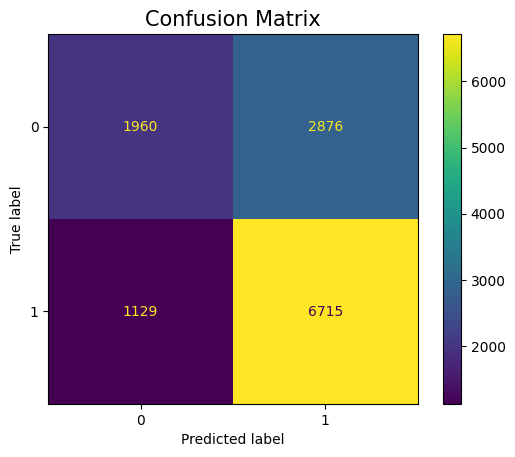

In [751]:
matrix = confusion_matrix(y_test_rf, y_pred_rf)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=clf.classes_)
display.plot()
plt.title('Confusion Matrix', fontsize=15)
plt.show()

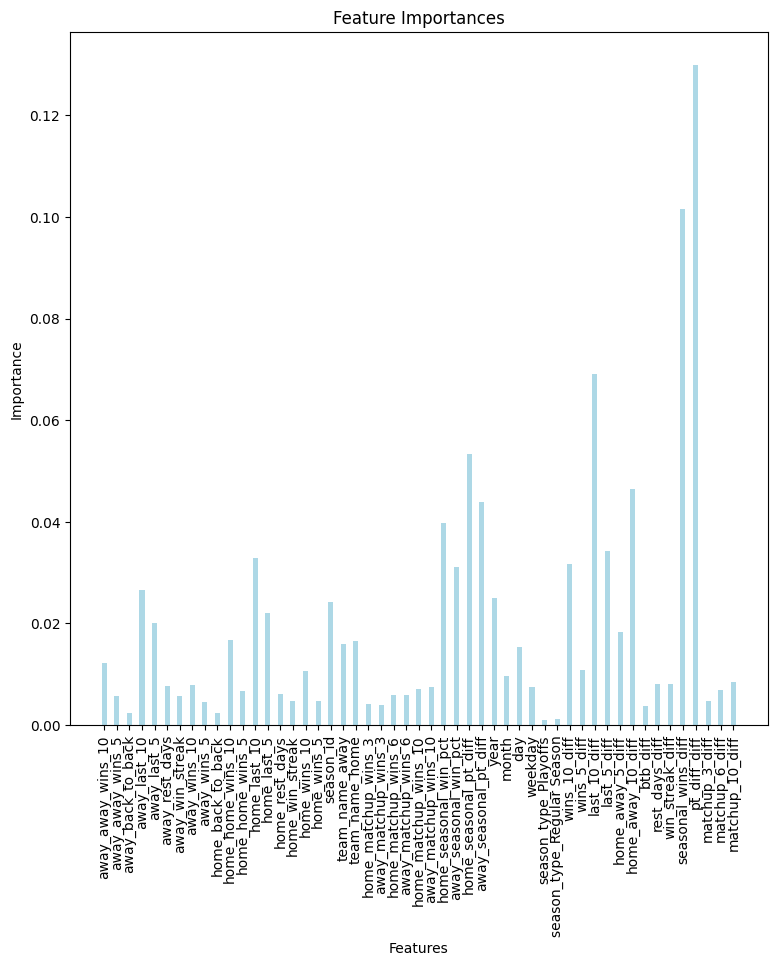

In [752]:
importances = clf.feature_importances_
features = X_rf.columns.to_list()

plt.figure(figsize=(9, 9))
plt.title("Feature Importances")

bar = plt.bar(features, importances, color ='lightblue', width = 0.4)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.show()

## Neural Network

In [708]:
# games_test = games.copy()

# games_test = games_test[['home_home_wins_10', 'away_away_wins_10', 'home_last_10', 'away_last_10',
#                          'season_id', 'home_wins_10', 'away_wins_10', 'home_seasonal_win_pct',
#                          'away_seasonal_win_pct', 'home_seasonal_pt_diff', 'away_seasonal_pt_diff',
#                          'year', 'day', 'team_name_home', 'team_name_away', 'wl_home']]

In [773]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

games_pca = games.copy()

# print(games.columns)

games_cont = games[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
       'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
       'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
       'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
       'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
       'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
       'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']]
scaled = scaler.fit_transform(games_cont)
games_pca[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
       'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
       'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
       'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
       'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
       'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
       'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']] = scaled

features = games_pca.drop(['wl_home'], axis=1)
# pca = PCA(n_components=25)
pca = PCA(n_components=23)
features_pca = pca.fit_transform(features)

df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])
df_pca['wl_home'] = games_pca['wl_home'].values


Index(['away_away_wins_10', 'away_away_wins_5', 'away_back_to_back',
       'away_last_10', 'away_last_5', 'away_rest_days', 'away_win_streak',
       'away_wins_10', 'away_wins_5', 'home_back_to_back', 'home_home_wins_10',
       'home_home_wins_5', 'home_last_10', 'home_last_5', 'home_rest_days',
       'home_win_streak', 'home_wins_10', 'home_wins_5', 'season_id',
       'team_name_away', 'team_name_home', 'wl_home', 'home_matchup_wins_3',
       'away_matchup_wins_3', 'home_matchup_wins_6', 'away_matchup_wins_6',
       'home_matchup_wins_10', 'away_matchup_wins_10', 'home_seasonal_win_pct',
       'away_seasonal_win_pct', 'home_seasonal_pt_diff',
       'away_seasonal_pt_diff', 'year', 'month', 'day', 'weekday',
       'season_type_Playoffs', 'season_type_Regular Season', 'wins_10_diff',
       'wins_5_diff', 'last_10_diff', 'last_5_diff', 'home_away_5_diff',
       'home_away_10_diff', 'btb_diff', 'rest_days_diff', 'win_streak_diff',
       'seasonal_wins_diff', 'pt_diff_diff', '

In [767]:
X = df_pca.drop('wl_home', axis=1)
y = df_pca['wl_home']

# X = games_test.drop('wl_home', axis=1)
# y = games_test['wl_home']

In [769]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# scaler = StandardScaler()
# X_train_cont = X_train[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
#        'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
#        'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
#        'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
#        'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
#        'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
#        'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']]
# X_test_cont = X_test[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
#        'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
#        'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
#        'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
#        'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
#        'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
#        'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']]
# scaled_train = scaler.fit_transform(X_train_cont)
# scaled_test = scaler.transform(X_test_cont)

# X_train[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
#        'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
#        'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
#        'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
#        'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
#        'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
#        'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']] = scaled_train
# X_test[['home_last_5', 'away_last_5', 'home_last_10', 'away_last_10', 'home_wins_5',
#        'away_wins_5', 'home_wins_10', 'away_wins_10', 'home_win_streak', 'away_win_streak',
#        'home_rest_days', 'away_rest_days', 'home_matchup_wins_3', 'away_matchup_wins_3', 
#        'home_matchup_wins_6', 'away_matchup_wins_6', 'home_matchup_wins_10', 
#        'away_matchup_wins_10', 'home_seasonal_win_pct', 'away_seasonal_win_pct', 
#        'home_seasonal_pt_diff', 'away_seasonal_pt_diff', 'wins_10_diff',
#        'seasonal_wins_diff', 'pt_diff_diff', 'last_10_diff']] = scaled_test


# scaler = StandardScaler()

# X_train_cont = X_train[['home_home_wins_10', 'away_away_wins_10', 'home_last_10', 'away_last_10',
#                          'home_wins_10', 'away_wins_10', 'home_seasonal_win_pct',
#                          'away_seasonal_win_pct', 'home_seasonal_pt_diff', 'away_seasonal_pt_diff']]
# X_test_cont = X_test[['home_home_wins_10', 'away_away_wins_10', 'home_last_10', 'away_last_10',
#                          'home_wins_10', 'away_wins_10', 'home_seasonal_win_pct',
#                          'away_seasonal_win_pct', 'home_seasonal_pt_diff', 'away_seasonal_pt_diff']]
# scaled_train = scaler.fit_transform(X_train_cont)
# scaled_test = scaler.transform(X_test_cont)

In [770]:
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import LeakyReLU

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),

    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [771]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100


1268/1268 ━━━━━━━━━━━━━━━━━━━━ 2s 867us/step - accuracy: 0.5312 - loss: 31.8692 - val_accuracy: 0.6365 - val_loss: 0.9699
Epoch 2/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step - accuracy: 0.5490 - loss: 8.2389 - val_accuracy: 0.6104 - val_loss: 1.4764
Epoch 3/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.5678 - loss: 4.9397 - val_accuracy: 0.6250 - val_loss: 0.9065
Epoch 4/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.5790 - loss: 3.7545 - val_accuracy: 0.6110 - val_loss: 1.9088
Epoch 5/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.5961 - loss: 3.0539 - val_accuracy: 0.5865 - val_loss: 3.0245
Epoch 6/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.6042 - loss: 2.5666 - val_accuracy: 0.6504 - val_loss: 0.9826
Epoch 7/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.6020 - loss: 2.0130 - val_accuracy: 0.6296 - val_loss: 1.4135
Epoch 8/100
1268/1268 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - accuracy: 0.6140 - lo

In [777]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print('Accuracy: ', test_accuracy)
print('Loss: ', test_loss)

397/397 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.6809 - loss: 0.6074
Accuracy:  0.6793375611305237
Loss:  0.605821967124939


## ARIMA

In [775]:
print(np.ones((10, 3, 5)))

[[[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]

 [[1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1.]]]
